# PID Controller Simulation

## Description

### System:
1D Drone control

### Goal:
Produce a control loop to keep a drone hovering at a specified height, in the face of a constant g and random wind.

Use numerical derivatives and integration to control the drone's height.

## 1. Setup:
Create a sketch of the system with a free body diagram.

## 1a) Introduce setpoint, measurement and error
We can only control the Force (acceleration) of the drone, via a "gas pedal". We have constant gravitation.

## 2. Create a simulation (multi-part)


### 2a) P controller
Signal proportional to: setpoint - measurement = error
$$u(t) = K_p e(t)$$
put into Euler-Cromer simulation.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [ ]:
def calculate_error(setpoint:float, measurement:float) -> float:
    """
    Calculate the error between the setpoint and the measurement.

    Parameters
    ----------
    setpoint: float
        Desired value.
    measurement: float
        Current system state.

    Returns
    -------
    error: float 
        The difference between setpoint and measurement.
    """
    return setpoint - measurement

def proportional_term(k_p:float, error:float) -> float:
    """
    Proportional term for a PID controller.

    Parameters
    ----------
    k_p: float
        Proportional gain.
    error: float
        The error value.

    Returns
    -------
    P: float 
        Control force based on proportional error.
    """
    return k_p * error


def acceleration(u:float, m:float, g:float) -> float:
    """
    Calculate the net vertical acceleration of a mass under control and gravity.

    Parameters
    ----------
    u: float
        Control input (force from thrusters).
    m: float
        Mass of the drone.
    g: float
        Gravitational acceleration.

    Returns
    -------
    a: float 
        Net acceleration 
    """
    return (u - m * g) / m

In [30]:
## initialize the system
m = 1.0  # mass
setpoint = 10.0 # desired position
start_position = 0.0 # initial position
start_velocity = 0.0 # initial velocity
g = 9.81  # gravitational acceleration
K_p = 5.0  # proportional gain


n = 500
T = np.linspace(0, 20, n)  # time vector
dt = T[1] - T[0]  # time step

position = np.zeros(n)  # position
velocity = np.zeros(n)  # velocity
position[0] = start_position  # set initial position
velocity[0] = start_velocity  # set initial velocity


# Euler cromer method for numerical integration
for i in range(1, n):
    # Calculate the control input using the proportional term
    error = calculate_error(setpoint, position[i-1])
    u = proportional_term(K_p, error)

    # Calculate the acceleration
    a = acceleration(u, m, g)

    # Update velocity and position using Euler-Cromer method
    velocity[i] = velocity[i-1] + a * dt
    position[i] = position[i-1] + velocity[i] * dt

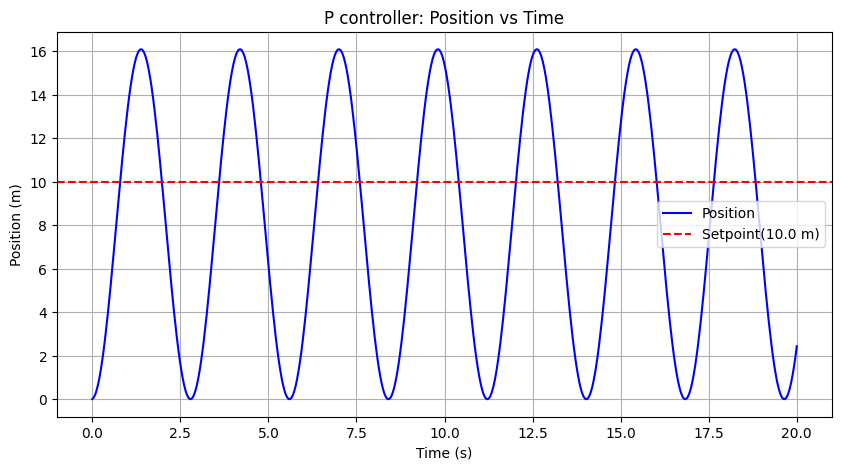

In [31]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position', color='blue')
plt.axhline(setpoint, color='red', linestyle='--', label=f'Setpoint({setpoint} m)')
plt.title('P controller: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()    

### 2b) PD controller
Signal proportional to error + derivative of error
$$u(t) = K_p e(t) + K_D \frac{∂ e(t)}{∂ t}$$
Implement the derivative of the error into the simulation.
A simple way of calculating the derivative is to use the difference between the current and previous error:
$$\frac{∂ e(t)}{∂ t} = \frac{e(t) - e(t-1)}{Δt}$$

In [5]:
def derivative_term(K_d, current_error, previous_error, dt):
    """
    Derivative term for a PID controller.

    Parameters:
    K_d (float): Derivative gain.
    current_error (float): Current error.
    previous_error (float): Previous error.
    dt (float): Time step.

    Returns:
    float: Control force based on derivative of error.
    """
    derivative = (current_error - previous_error) / dt
    return K_d * derivative

In [25]:
K_p = 2.0  # proportional gain
K_d = 5.0  # derivative gain

position = np.zeros(n)  # position
velocity = np.zeros(n)  # velocity
position[0] = start_position  # set initial position
velocity[0] = start_velocity  # set initial velocity

previous_error = calculate_error(setpoint, position[0])  # initialize previous error

for i in range(1, n):
    error = calculate_error(setpoint, position[i-1])  # calculate error

    # Calculate the control input using the proportional term
    u = proportional_term(K_p, error)

    # Calculate the derivative term
    derivative = derivative_term(K_d, error, previous_error, dt)

    u += derivative  # add derivative term to control input

    # Calculate the acceleration
    a = acceleration(u, m, g)

    # Update velocity and position using Euler-Cromer method
    velocity[i] = velocity[i-1] + a * dt
    position[i] = position[i-1] + velocity[i] * dt

    previous_error = error  # update previous error for next iteration

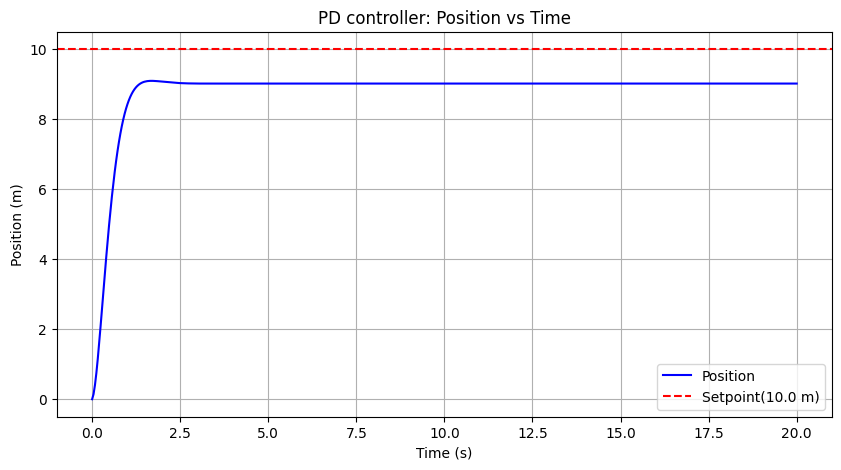

In [7]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position', color='blue')
plt.axhline(setpoint, color='red', linestyle='--', label=f'Setpoint({setpoint} m)')
plt.title('PD controller: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()    

### 2C) PID controller
Now its time to introduce the final term of the controlller, the integral term.
$$u(t) = K_p e(t) + K_I \int_0^t e(t) dt + K_D \frac{∂ e(t)}{∂ t} $$
Implement the integral of the error into the simulation by using a simple numerical integration method, such as a Riemann sum:
$$\int_0^t e(t) dt \approx \sum_{i=0}^{n} e(t_i) \Delta t$$

In [8]:
def integration_term(K_i, accumulated_error, dt):
    """
    Integral term for a PID controller.

    Parameters:
    K_i (float): Integral gain.
    accumulated_error (float): Accumulated error over time.
    dt (float): Time step.

    Returns:
    float: Control force based on integral of error.
    """
    return K_i * accumulated_error * dt

In [9]:
K_p = 10.0  # proportional gain
K_d = 5.0   # derivative gain
K_i = 5.0  # integral gain

position = np.zeros(n)  # position
velocity = np.zeros(n)  # velocity
position[0] = start_position  # set initial position
velocity[0] = start_velocity  # set initial velocity

previous_error = calculate_error(setpoint, position[0])  # initialize previous error
accumulated_error = previous_error

for i in range(1, n):
    # Calculate the error
    error = calculate_error(setpoint, position[i-1])
    # Update accumulated error for integral term
    accumulated_error += error

    # Calculate the control input using the proportional term
    u = proportional_term(K_p, error)

    # Calculate the derivative term
    derivative = derivative_term(K_d, error, previous_error, dt)

    # Calculate the integral term
    integral = integration_term(K_i, accumulated_error, dt)

    u = u + derivative + integral  # add derivative and integral terms to control input

    # Calculate the acceleration
    a = acceleration(u, m, g)

    # Update velocity and position using Euler-Cromer method
    velocity[i] = velocity[i-1] + a * dt
    position[i] = position[i-1] + velocity[i] * dt

    previous_error = error  # update previous error for next iteration

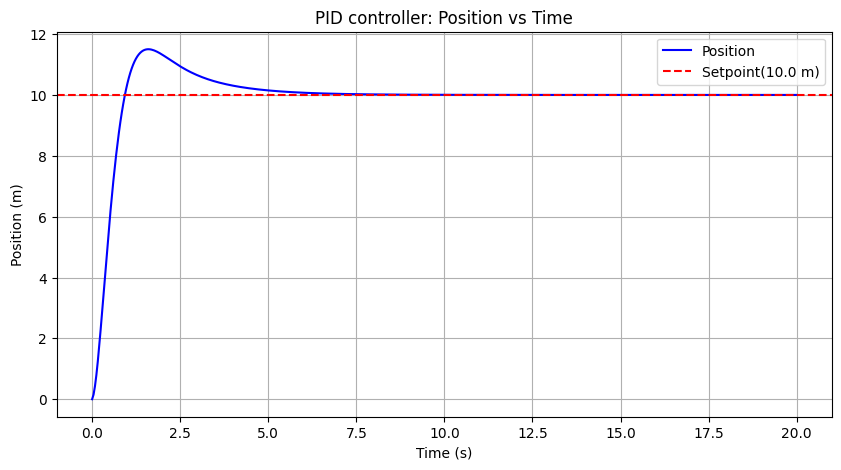

In [10]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position', color='blue')
plt.axhline(setpoint, color='red', linestyle='--', label=f'Setpoint({setpoint} m)')
plt.title('PID controller: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()

## 3. Add random effects
### Examples: 
- Wind gusts
- Air resistance
- Moving setpoint

In [11]:
def drag_force(v, drag_coeff=5):
    """
    Calculate the drag force acting on the object.

    Parameters:
    v (float): Current velocity of the object.
    drag_coeff (float): Coefficient of drag.

    Returns:
    float: Drag force acting on the object.
    """
    return -drag_coeff * v

def wind_force(wind_amplitude=5):
    """
    Calculate the wind force acting on the object.

    Parameters:
    t (float): Current time.
    wind_amplitude (float): Amplitude of the wind force.

    Returns:
    float: Wind force acting on the object.
    """
    return np.random.uniform(-wind_amplitude, wind_amplitude)


In [12]:


K_p = 10.0  # proportional gain
K_d = 10.0   # derivative gain
K_i = 10.0   # integral gain

# Simulate the system with external forces
position = np.zeros(n)  # position
velocity = np.zeros(n)  # velocity
position[0] = start_position  # set initial position
velocity[0] = start_velocity  # set initial velocity


previous_error = calculate_error(setpoint, position[0])  # initialize previous error
accumulated_error = previous_error

for i in range(1, n):
    # Calculate the error
    error = calculate_error(setpoint, position[i-1])
    # Update accumulated error for integral term
    accumulated_error += error

    # Calculate the control input using the proportional term
    u = proportional_term(K_p, error)

    # Calculate the derivative term
    derivative = derivative_term(K_d, error, previous_error, dt)

    # Calculate the integral term
    integral = integration_term(K_i, accumulated_error, dt)

    u = u + derivative + integral  # add derivative and integral terms to control input

    # Calculate the acceleration
    a = acceleration(u, m, g)
    a += (wind_force(wind_amplitude=5) + drag_force(velocity[i-1], drag_coeff=1))  / m  # add external forces

    # Update velocity and position using Euler-Cromer method
    velocity[i] = velocity[i-1] + a * dt
    position[i] = position[i-1] + velocity[i] * dt

    previous_error = error  # update previous error for next iteration

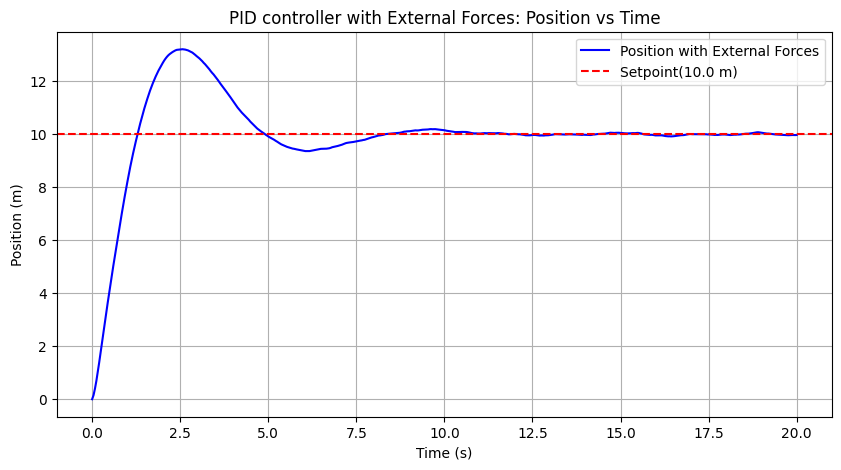

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position with External Forces', color='blue')
plt.axhline(setpoint, color='red', linestyle='--', label=f'Setpoint({setpoint} m)')
plt.title('PID controller with External Forces: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()

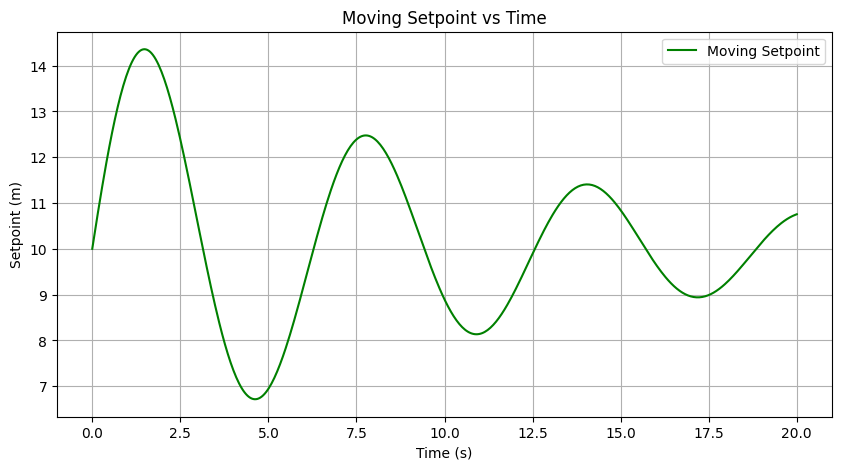

In [14]:
## Moving setpoint
def moving_setpoint(t):
    """
    Define a moving setpoint that changes over time.

    Parameters:
    t (float): Current time.

    Returns:
    float: Setpoint value at time t.
    """
    return 10.0 + 5.0 * np.sin(1.0 * t) * np.exp(-0.09 * t)

#plot the moving setpoint
moving_setpoints = moving_setpoint(T)
plt.figure(figsize=(10, 5))
plt.plot(T, moving_setpoints, label='Moving Setpoint', color='green')
plt.title('Moving Setpoint vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Setpoint (m)')
plt.legend()
plt.grid()
plt.show()

In [15]:


K_p = 10.0  # proportional gain
K_d = 10.0   # derivative gain
K_i = 10.0   # integral gain

# Simulate the system with external forces
position = np.zeros(n)  # position
velocity = np.zeros(n)  # velocity
position[0] = start_position  # set initial position
velocity[0] = start_velocity  # set initial velocity


previous_error = calculate_error(moving_setpoints[0], position[0])  # initialize previous error
accumulated_error = previous_error

for i in range(1, n):
    # Calculate the error
    error = calculate_error(moving_setpoints[i], position[i-1])
    # Update accumulated error for integral term
    accumulated_error += error

    # Calculate the control input using the proportional term
    u = proportional_term(K_p, error)

    # Calculate the derivative term
    derivative = derivative_term(K_d, error, previous_error, dt)

    # Calculate the integral term
    integral = integration_term(K_i, accumulated_error, dt)

    u = u + derivative + integral  # add derivative and integral terms to control input

    # Calculate the acceleration
    a = acceleration(u, m, g)
    a += (wind_force(wind_amplitude=5) + drag_force(velocity[i-1], drag_coeff=1))  / m  # add external forces

    # Update velocity and position using Euler-Cromer method
    velocity[i] = velocity[i-1] + a * dt
    position[i] = position[i-1] + velocity[i] * dt

    previous_error = error  # update previous error for next iteration

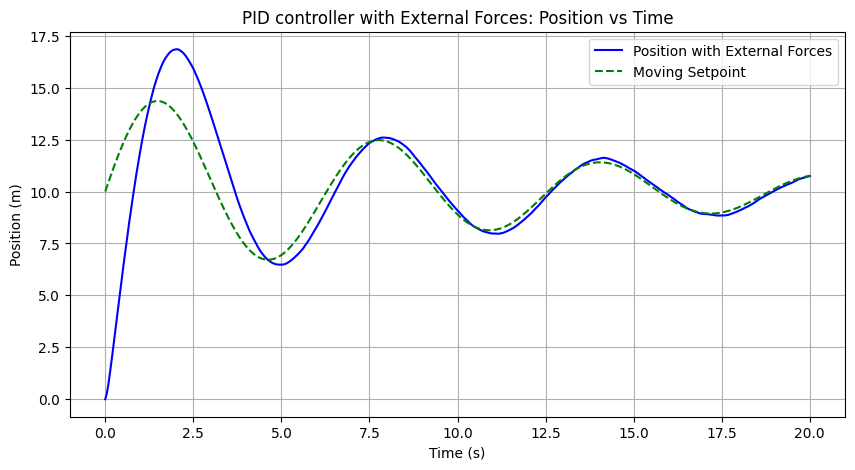

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position with External Forces', color='blue')
plt.plot(T, moving_setpoints, label='Moving Setpoint', color='green', linestyle='--')
plt.title('PID controller with External Forces: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()